# PROJET 7:Développez une preuve de concept

## SOMMAIRE  <a class="anchor" id="sommaire"></a>
## [IMPORT DES LIBRAIRIES](#1)<a class="anchor" id="sommaire"></a>
## [MODELE DE BASE](#2)<a class="anchor" id="sommaire"></a>
## [MODELE ARCHITECTURE BERT](#3)<a class="anchor" id="sommaire"></a>
## [MODELE FAST BERT](#4)<a class="anchor" id="sommaire"></a>
## [MODELE XLNET](#5)<a class="anchor" id="sommaire"></a>
## [COMPARAISON](#6)<a class="anchor" id="sommaire"></a>



In [3]:
## [IMPORT DES LIBRAIRIES](#sommaire)<a class="anchor" id="1"></a>

In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import nltk
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
import wordcloud
from time import time
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.decomposition import NMF, LatentDirichletAllocation
from gensim.models.coherencemodel import CoherenceModel
import gensim
import gensim.corpora as corpora
from gensim.test.utils import datapath
from gensim import utils
import gensim.models
import pprint
#from sklearn.multioutput import 
import pickle
from sklearn.multioutput import MultiOutputClassifier
#import yake
from sklearn.metrics import jaccard_score
from sklearn.metrics import hamming_loss
import torch
import os
import math

import torch
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, XLNetTokenizer, XLNetModel, XLNetLMHeadModel, XLNetConfig
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
#Loading data
data=pd.read_csv("DataNLP.csv")

In [6]:
#Building a specific corpus format for some future algorithms
def expandlist(x):
    for i in range(len(x)):
        if i==0:
            strb=str(x[i])
        else:
            strb+=' '+str(x[i])
    return strb

In [7]:
def unpack(x):
    x1=x.replace('[\'','').replace('\', \'',' ').replace('\']','')
    return x1
tokenizer = nltk.RegexpTokenizer(r'\w+')
data['FullLem']=data['FullLemExpand'].apply(lambda x:tokenizer.tokenize(x))
data['FullToken']=data['FullToken'].apply(lambda x:tokenizer.tokenize(unpack(x)))
data['TokenTags']=data['TokenTags'].apply(lambda x:tokenizer.tokenize(unpack(x)))

In [8]:
#initializing list of tags
listetag=[]
for i in data['TokenTags']:
    for j in i:
        listetag.append(j)
Tag=pd.DataFrame(listetag)
liste_frequent_tag=[i for i in Tag[0].value_counts().head(50).index]

In [9]:
for i in range(0,30):
    if str(i) in liste_frequent_tag:
        liste_frequent_tag.remove(str(i))
data['TokenFrequentTags']=0
data['TokenFrequentTags']=data['TokenTags'].apply(lambda x:[w for w in x if w in liste_frequent_tag])
data['NumberFrequentTags']=data['TokenFrequentTags'].apply(lambda x:len(x))

In [10]:
#We only keep posts with a tag and less than 5 tags
data2=data[(data['NumberFrequentTags']!=0)&(data['NumberFrequentTags']<5)]
#New Dataframe
data3=pd.DataFrame(data2['Bodyclean'])
data3['TokenFrequentTags']=data2['TokenFrequentTags']

In [11]:
for i in liste_frequent_tag:
    data3[i]=0
    data3[i]=data3['TokenFrequentTags'].apply(lambda x:1 if i in x else 0)
y=data3[liste_frequent_tag].values

In [71]:
data3['FullLem']=data2['FullLem']
data3['FullLemExpand']=data3['FullLem'].apply(lambda x:expandlist(x))        

In [12]:
data3

,Bodyclean,TokenFrequentTags,c,android,python,javascript,java,net,git,sql,...,angular,iphone,http,web,spring,list,shell,xcode,regex,eclipse
0,Here is a piece of C++ code that shows some ve...,"[java, c]",1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,I accidentally committed the wrong files to Gi...,"[git, git]",0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,I want to delete a branch both locally and rem...,"[git, git, git, git]",0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,What are the differences between git pull and ...,"[git, git, git]",0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,What is the use of the yield keyword in Python...,[python],0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49992,I've run into an error when installing the Win...,"[windows, visual, c]",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49994,"Ok folks.. long story short, I was developing ...","[android, android]",0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49995,"Today, I got completely surprised when I saw t...",[javascript],0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49997,In razor engine I have used LabelFor helper me...,"[asp, net, mvc, html]",0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
b=[]
for j in data3.index:
    b.append([data3.at[j,i]for i in liste_frequent_tag])


In [14]:
data3['labels']=b

In [15]:
data4 = pd.DataFrame(data3[['Bodyclean','labels']], columns=['Bodyclean', 'labels'])
data4=data4.rename(columns={'Bodyclean':'text'})

In [150]:
data4

,text,labels
0,Here is a piece of C++ code that shows some ve...,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,I accidentally committed the wrong files to Gi...,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,I want to delete a branch both locally and rem...,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,What are the differences between git pull and ...,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,What is the use of the yield keyword in Python...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
49992,I've run into an error when installing the Win...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
49994,"Ok folks.. long story short, I was developing ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
49995,"Today, I got completely surprised when I saw t...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
49997,In razor engine I have used LabelFor helper me...,"[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."


## [MODELE DE BASE](#sommaire)<a class="anchor" id="2"></a>

##### Calcul séparé

In [119]:
X= data3['FullLemExpand']
y=data3[liste_frequent_tag].values

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [121]:
t0 = time()
vectorizer = TfidfVectorizer(max_features=1000)
X_train = vectorizer.fit_transform(X_train).toarray()
print("done in %0.3fs." % (time() - t0))
t0 = time()

done in 2.796s.


In [123]:
X_test = vectorizer.transform(X_test).toarray()
print("done in %0.3fs." % (time() -t0))

done in 27.063s.


In [126]:
from sklearn.ensemble import ExtraTreesClassifier
clf2 = ExtraTreesClassifier(n_estimators=100, random_state=0)
t0 = time()
clf2.fit(X_train, y_train)
runtime=(time() - t0)

print("done in %0.3fs." % runtime)
score=clf2.score(X_test,y_test)
print(score)

done in 487.435s.
0.46075303126994255


In [127]:
from sklearn.svm import LinearSVC
clf9 = MultiOutputClassifier(LinearSVC())

t0 = time()

clf9.fit(X_train, y_train)
runtime=(time() - t0)

print("done in %0.3fs." % runtime)
score2=clf9.score(X_test,y_test)
print(score2)


done in 19.858s.
0.4639438417358009


## [MODELE ARCHITECTURE BERT](#sommaire)<a class="anchor" id="3"></a>

Le premier modèle implémenté est basé sur la librairie simpletransformers qui permet d'effectuer de la classification multilabel. Pour ce projet, nous allons utiliser le modèle distilbert, qui est un modèle "disillé" contenant moins de paramètres que d'autres modèles Bert. 

In [143]:
from simpletransformers.classification import MultiLabelClassificationModel

In [156]:
model = MultiLabelClassificationModel('distilbert', 'distilbert-base-uncased', num_labels=48,use_cuda=False, args=
                                      {'multi_label':True,
                                    
                                       'train_batch_size':16,
                                       'reprocess_input_data': True, 
                                       'overwrite_output_dir': True, 
                                       'num_train_epochs': 3, 
                                       'silent': False})

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForMultiLabelSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForMultiLabelSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier

In [145]:
import pickle

In [146]:
from sklearn.model_selection import train_test_split

In [48]:
train, test = train_test_split(data4,test_size = 0.15)

In [157]:
model.train_model(train)

i:\Users\jeant\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


(6660, 0.073857532758909)

In [158]:
pickle.dump( model, open( "first_model_2_epochs.p", "wb" ) )

In [159]:
test

,text,labels
23463,"I searched a lot, but nowhere is it written ho...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
41721,I'm looking into ways to use SASS (Syntactical...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
33418,I have a mssql database for my website within ...,"[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
26037,"I am learning ember.js, and I am trying to und...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
42572,Does API provide a method to use the followin...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
22082,I have some code that makes a call to a third ...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
43354,"In python, is there a function to check if a g...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
40357,So I'm trying to update the text on a UIButton...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
37842,"I have a sql statement in my model,\nI then sa...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, ..."


In [160]:
test=test.reset_index()

In [161]:
predictions, raw_outputs = model.predict(test['text'])

In [29]:
predictbis=pd.DataFrame(predictions)
predictbis

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6263,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6264,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6265,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6266,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
predictbis.to_csv("prediction_distilbert_simple_transformer.csv")

In [31]:
listb=[]
for i in test['labels']:
    listb.append(i)
    

In [32]:
listk=np.asarray(listb)

In [35]:
from sklearn.metrics import accuracy_score
accuracy_score(listk,predictbis.values)

0.44591576260370136

## [MODELE FAST BERT](#sommaire)<a class="anchor" id="4"></a>

Le modèle fast bert est une implémentation du modèle BERT avec le tokenizer de la bibliothèque fastAI. Il semble y avoir un problème d'implémentation: les paramètres implémentent une classification multiclasse. 

In [19]:
data5=pd.DataFrame(data3)
data5=data5.rename(columns={'Bodyclean':'text'})
data5=data5.drop(['TokenFrequentTags','labels'], axis=1)


In [80]:
from sklearn.model_selection import train_test_split
train,test=train_test_split(data5,test_size=0.135, random_state=42)
test,val=train_test_split(test,test_size=0.5, random_state=42)

In [81]:
train.to_csv('train.csv')
val.to_csv('val.csv')

In [92]:
from fast_bert.data_cls import BertDataBunch

databunch = BertDataBunch('./content/drive/My Drive', './content/drive/My Drive',
                          tokenizer='bert-base-uncased',
                          train_file='train.csv',
                          val_file='val.csv',
                          label_file='labels.csv',
                          text_col='text',
                          label_col=liste_frequent_tag,
                          batch_size_per_gpu=4,
                          max_seq_length=512,
                          multi_gpu=False,
                          multi_label=True,
                          model_type='bert')

In [93]:
pickle.dump( databunch, open( "databunch.p", "wb" ) )

In [84]:
databunch=pickle.load(open('databunch.p','rb'))

In [86]:
from fast_bert.learner_cls import BertLearner
from fast_bert.metrics import accuracy
import logging

logger = logging.getLogger()
device_cuda = torch.device("cpu")
metrics = [{'name': 'accuracy', 'function': accuracy}]

learner = BertLearner.from_pretrained_model(
						databunch,
						pretrained_path='bert-base-uncased',
						metrics=metrics,
						device=device_cuda,
						logger=logger,
						output_dir='',
						finetuned_wgts_path=None,
						warmup_steps=500,
						multi_gpu=False,
						is_fp16=False,
						multi_label=True,
						logging_steps=50)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not 

In [87]:
pickle.dump( learner, open( "learner2.p", "wb" ) )

In [21]:
learner.fit(epochs=1,
			lr=6e-5,
			validate=True, 	# Evaluate the model after each epoch
			schedule_type="warmup_cosine",
			optimizer_type="lamb")

i:\Users\jeant\anaconda3\lib\site-packages\pytorch_lamb\lamb.py:96: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:882.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)


i:\Users\jeant\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:247: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


(282, 0.6904001631212573)

In [22]:
pickle.dump( learner, open( "third_model_2_fastbert.p", "wb" ) )

In [28]:
infile = open('third_model_2_fastbert.p','rb')

In [29]:
learner=pickle.load(infile)

In [24]:
test=test.reset_index()

In [30]:
predictions = learner.predict_batch(test['text'].to_list())

i:\Users\jeant\anaconda3\lib\site-packages\pandas\core\frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(


In [37]:
test.head()

,index,text,c,android,python,javascript,java,net,git,sql,...,angular,iphone,http,web,spring,list,shell,xcode,regex,eclipse
0,24493,I am having issues with the calculation of whe...,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2359,How can I switch between opened windows in Ecl...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,12769,"How to convert a string in the format ""%d/%m/%...",0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,13984,"I've been using Git for a while now, and I rec...",0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,43473,I am looking for a good and well developed lib...,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
preds2=pd.DataFrame()
for i in liste_frequent_tag:
    preds2[i]=preds[i].copy()

In [47]:
preds2

,c,android,python,javascript,java,net,git,sql,html,jquery,...,angular,iphone,http,web,spring,list,shell,xcode,regex,eclipse
0,0.658432,0.607023,0.402399,0.538035,0.385865,0.462306,0.349449,0.350204,0.593162,0.502200,...,0.468886,0.501253,0.364833,0.477087,0.442965,0.514882,0.498070,0.477869,0.403296,0.616465
1,0.672288,0.609894,0.410228,0.562674,0.369724,0.492794,0.375700,0.369234,0.609932,0.487579,...,0.446002,0.491803,0.364096,0.468334,0.451870,0.524256,0.493422,0.481335,0.392756,0.645642
2,0.656323,0.540806,0.350004,0.607908,0.458192,0.454352,0.425978,0.435165,0.636337,0.606063,...,0.403792,0.562905,0.340269,0.438589,0.440910,0.525313,0.565337,0.494458,0.500969,0.588655
3,0.659733,0.579093,0.419389,0.579761,0.356248,0.475679,0.357782,0.351800,0.629342,0.475512,...,0.473299,0.445034,0.322051,0.523836,0.455351,0.468784,0.483630,0.502987,0.453840,0.671492
4,0.663239,0.580568,0.397389,0.567935,0.391123,0.456250,0.369571,0.368504,0.630344,0.491802,...,0.448742,0.492944,0.352211,0.473274,0.452398,0.516146,0.507887,0.478978,0.413712,0.626166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,0.651400,0.597389,0.419718,0.558952,0.366705,0.468889,0.357254,0.356052,0.601622,0.452226,...,0.484394,0.494638,0.329649,0.479451,0.433043,0.504693,0.500438,0.480841,0.427559,0.600477
560,0.656649,0.523249,0.388821,0.597529,0.380646,0.492219,0.388372,0.398144,0.641440,0.505194,...,0.429470,0.466363,0.333719,0.458323,0.478755,0.485795,0.479085,0.497840,0.431370,0.649640
561,0.673988,0.639071,0.392920,0.549662,0.405798,0.452867,0.338830,0.368425,0.584178,0.505852,...,0.455133,0.536585,0.347150,0.456866,0.417964,0.521143,0.550403,0.492704,0.418130,0.573745
562,0.671281,0.591390,0.363463,0.592980,0.398365,0.497317,0.387146,0.371283,0.626631,0.497510,...,0.493001,0.479540,0.339669,0.454987,0.451967,0.477394,0.489734,0.465365,0.451712,0.650001


In [38]:
predictor = BertClassificationPredictor(
				model_path='./model_out',
				label_path='', # location for labels.csv file
				multi_label=True,
				model_type='bert',
				do_lower_case=False,
				device=None)

In [46]:
single_prediction = predictor.predict(test2['text'][1])

## [MODELE XLNET](#sommaire)<a class="anchor" id="5"></a>

Nous implémentons ici une architecture XLNET directement avec pytorch. Il s'agit d'un code tiré du notebook colab:
    https://colab.research.google.com/drive/1o3cv-YSPGiKftCvFnCiMcygARqdaxrM7#scrollTo=pxCN5nLvOO2a

In [55]:
train, test = train_test_split(data3,test_size = 0.15)

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [52]:
def plot_sentence_embeddings_length(text_list, tokenizer):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), text_list))
    tokenized_texts_len = list(map(lambda t: len(t), tokenized_texts))
    fig, ax = plt.subplots(figsize=(8, 5));
    ax.hist(tokenized_texts_len, bins=40);
    ax.set_xlabel("Length of Comment Embeddings");
    ax.set_ylabel("Number of Comments");
    return

tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

In [56]:
train_text_list = train["Bodyclean"].values
test_text_list = test["Bodyclean"].values

In [57]:
def tokenize_inputs(text_list, tokenizer, num_embeddings=512):
    """
    Tokenizes the input text input into ids. Appends the appropriate special
    characters to the end of the text to denote end of sentence. Truncate or pad
    the appropriate sequence length.
    """
    # tokenize the text, then truncate sequence to the desired length minus 2 for
    # the 2 special characters
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:num_embeddings-2], text_list))
    # convert tokenized text into numeric ids for the appropriate LM
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    # append special token "<s>" and </s> to end of sentence
    input_ids = [tokenizer.build_inputs_with_special_tokens(x) for x in input_ids]
    # pad sequences
    input_ids = pad_sequences(input_ids, maxlen=num_embeddings, dtype="long", truncating="post", padding="post")
    return input_ids

def create_attn_masks(input_ids):
    """
    Create attention masks to tell model whether attention should be applied to
    the input id tokens. Do not want to perform attention on padding tokens.
    """
    # Create attention masks
    attention_masks = []

    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return attention_masks

In [58]:
train_input_ids = tokenize_inputs(train_text_list, tokenizer, num_embeddings=250)
train_input_ids

array([[  216,    26,    23, ...,     0,     0,     0],
       [   33, 11921,    19, ...,    19,     4,     3],
       [   17,   150,   210, ...,  7574,     4,     3],
       ...,
       [   17,   150,    26, ...,     0,     0,     0],
       [   17,   150,    47, ...,     0,     0,     0],
       [  106,    17, 17477, ...,    17,     4,     3]])

In [59]:
test_input_ids = tokenize_inputs(test_text_list, tokenizer, num_embeddings=250)
test_input_ids

array([[ 160,   64,   17, ...,    0,    0,    0],
       [  17,  150,   30, ...,    0,    0,    0],
       [  17,  150,  125, ...,    0,    0,    0],
       ...,
       [  27,  105,   24, ...,   17,    4,    3],
       [ 143,   19,   52, ...,    0,    0,    0],
       [  64,  886, 3088, ...,    0,    0,    0]])

In [60]:
train_attention_masks = create_attn_masks(train_input_ids)
test_attention_masks = create_attn_masks(test_input_ids)


In [61]:
# add input ids and attention masks to the dataframe
train["features"] = train_input_ids.tolist()
train["masks"] = train_attention_masks

test["features"] = test_input_ids.tolist()
test["masks"] = test_attention_masks

<ipython-input-61-4f9b041f321c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["features"] = train_input_ids.tolist()
<ipython-input-61-4f9b041f321c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["masks"] = train_attention_masks
<ipython-input-61-4f9b041f321c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

In [62]:
# train valid split
train, valid = train_test_split(train, test_size=0.2, random_state=42)

In [63]:
X_train = train["features"].values.tolist()
X_valid = valid["features"].values.tolist()

train_masks = train["masks"].values.tolist()
valid_masks = valid["masks"].values.tolist()

label_cols = liste_frequent_tag
Y_train = train[label_cols].values.tolist()
Y_valid = valid[label_cols].values.tolist()

In [64]:
X_train = torch.tensor(X_train)
X_valid = torch.tensor(X_valid)

Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_valid = torch.tensor(Y_valid, dtype=torch.float32)

train_masks = torch.tensor(train_masks, dtype=torch.long)
valid_masks = torch.tensor(valid_masks, dtype=torch.long)

<ipython-input-64-ebb8a01c48c2>:7: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  train_masks = torch.tensor(train_masks, dtype=torch.long)
<ipython-input-64-ebb8a01c48c2>:8: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  valid_masks = torch.tensor(valid_masks, dtype=torch.long)


In [65]:
# Select a batch size for training
batch_size = 8

# Create an iterator of our data with torch DataLoader. This helps save on 
# memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(X_train, train_masks, Y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,\
                              sampler=train_sampler,\
                              batch_size=batch_size)

validation_data = TensorDataset(X_valid, valid_masks, Y_valid)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,\
                                   sampler=validation_sampler,\
                                   batch_size=batch_size)

In [66]:
def train(model, num_epochs,\
          optimizer,\
          train_dataloader, valid_dataloader,\
          model_save_path,\
          train_loss_set=[], valid_loss_set = [],\
          lowest_eval_loss=None, start_epoch=0,\
          device="cpu"
          ):
  """
  Train the model and save the model with the lowest validation loss
  """

  model.to(device)

  # trange is a tqdm wrapper around the normal python range
  for i in trange(num_epochs, desc="Epoch"):
    # if continue training from saved model
    actual_epoch = start_epoch + i

    # Training

    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0
    num_train_samples = 0

    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Clear out the gradients (by default they accumulate)
      optimizer.zero_grad()
      # Forward pass
      loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
      # store train loss
      tr_loss += loss.item()
      num_train_samples += b_labels.size(0)
      # Backward pass
      loss.backward()
      # Update parameters and take a step using the computed gradient
      optimizer.step()
      #scheduler.step()

    # Update tracking variables
    epoch_train_loss = tr_loss/num_train_samples
    train_loss_set.append(epoch_train_loss)

    print("Train loss: {}".format(epoch_train_loss))

    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Tracking variables 
    eval_loss = 0
    num_eval_samples = 0

    # Evaluate data for one epoch
    for batch in valid_dataloader:
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Telling the model not to compute or store gradients,
      # saving memory and speeding up validation
      with torch.no_grad():
        # Forward pass, calculate validation loss
        loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        # store valid loss
        eval_loss += loss.item()
        num_eval_samples += b_labels.size(0)

    epoch_eval_loss = eval_loss/num_eval_samples
    valid_loss_set.append(epoch_eval_loss)

    print("Valid loss: {}".format(epoch_eval_loss))

    if lowest_eval_loss == None:
      lowest_eval_loss = epoch_eval_loss
      # save model
      save_model(model, model_save_path, actual_epoch,\
                 lowest_eval_loss, train_loss_set, valid_loss_set)
    else:
      if epoch_eval_loss < lowest_eval_loss:
        lowest_eval_loss = epoch_eval_loss
        # save model
        save_model(model, model_save_path, actual_epoch,\
                   lowest_eval_loss, train_loss_set, valid_loss_set)
    print("\n")

  return model, train_loss_set, valid_loss_set


def save_model(model, save_path, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist):
  """
  Save the model to the path directory provided
  """
  model_to_save = model.module if hasattr(model, 'module') else model
  checkpoint = {'epochs': epochs, \
                'lowest_eval_loss': lowest_eval_loss,\
                'state_dict': model_to_save.state_dict(),\
                'train_loss_hist': train_loss_hist,\
                'valid_loss_hist': valid_loss_hist
               }
  torch.save(checkpoint, save_path)
  print("Saving model at epoch {} with validation loss of {}".format(epochs,\
                                                                     lowest_eval_loss))
  return
  
def load_model(save_path):
  """
  Load the model from the path directory provided
  """
  checkpoint = torch.load(save_path)
  model_state_dict = checkpoint['state_dict']
  model = XLNetForMultiLabelSequenceClassification(num_labels=model_state_dict["classifier.weight"].size()[0])
  model.load_state_dict(model_state_dict)

  epochs = checkpoint["epochs"]
  lowest_eval_loss = checkpoint["lowest_eval_loss"]
  train_loss_hist = checkpoint["train_loss_hist"]
  valid_loss_hist = checkpoint["valid_loss_hist"]
  
  return model, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist

In [67]:
class XLNetForMultiLabelSequenceClassification(torch.nn.Module):
  
  def __init__(self, num_labels=2):
    super(XLNetForMultiLabelSequenceClassification, self).__init__()
    self.num_labels = num_labels
    self.xlnet = XLNetModel.from_pretrained('xlnet-base-cased')
    self.classifier = torch.nn.Linear(768, num_labels)

    torch.nn.init.xavier_normal_(self.classifier.weight)

  def forward(self, input_ids, token_type_ids=None,\
              attention_mask=None, labels=None):
    # last hidden layer
    last_hidden_state = self.xlnet(input_ids=input_ids,\
                                   attention_mask=attention_mask,\
                                   token_type_ids=token_type_ids)
    # pool the outputs into a mean vector
    mean_last_hidden_state = self.pool_hidden_state(last_hidden_state)
    logits = self.classifier(mean_last_hidden_state)
        
    if labels is not None:
      loss_fct = BCEWithLogitsLoss()
      loss = loss_fct(logits.view(-1, self.num_labels),\
                      labels.view(-1, self.num_labels))
      return loss
    else:
      return logits
    
  def freeze_xlnet_decoder(self):
    """
    Freeze XLNet weight parameters. They will not be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = False
    
  def unfreeze_xlnet_decoder(self):
    """
    Unfreeze XLNet weight parameters. They will be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = True
    
  def pool_hidden_state(self, last_hidden_state):
    """
    Pool the output vectors into a single mean vector 
    """
    last_hidden_state = last_hidden_state[0]
    mean_last_hidden_state = torch.mean(last_hidden_state, 1)
    return mean_last_hidden_state
    
model = XLNetForMultiLabelSequenceClassification(num_labels=len(Y_train[0]))

In [68]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)


In [58]:
num_epochs=2

#cwd = os.getcwd()
model_save_path = "save.bin"
model, train_loss_set, valid_loss_set = train(model=model,\
                                              num_epochs=num_epochs,\
                                              optimizer=optimizer,\
                                              train_dataloader=train_dataloader,\
                                              valid_dataloader=validation_dataloader,\
                                              model_save_path=model_save_path,\
                                              device="cuda:0")


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.009267425153271521
Valid loss: 0.005965269664093993



Epoch:  50%|█████     | 1/2 [36:57<36:57, 2217.71s/it]

Saving model at epoch 0 with validation loss of 0.005965269664093993


Train loss: 0.005265692225331251
Valid loss: 0.005567381979917811



Epoch: 100%|██████████| 2/2 [1:13:55<00:00, 2217.86s/it]

Saving model at epoch 1 with validation loss of 0.005567381979917811




In [60]:
def generate_predictions(model, df, num_labels, device="cpu", batch_size=32):
  num_iter = math.ceil(df.shape[0]/batch_size)
  
  pred_probs = np.array([]).reshape(0, num_labels)
  
  model.to(device)
  model.eval()
  
  for i in range(num_iter):
    df_subset = df.iloc[i*batch_size:(i+1)*batch_size,:]
    X = df_subset["features"].values.tolist()
    
    masks = df_subset["masks"].values.tolist()
    X = torch.tensor(X)
    masks = torch.tensor(masks, dtype=torch.long)
    X = X.to(device)
    masks = masks.to(device)
    with torch.no_grad():
      logits = model(input_ids=X, attention_mask=masks)
      logits = logits.sigmoid().detach().cpu().numpy()
      pred_probs = np.vstack([pred_probs, logits])
  
  return pred_probs

In [62]:
num_labels = len(label_cols)
pred_probs = generate_predictions(model, test, num_labels, device="cuda:0", batch_size=8)
pred_probs

array([[1.61607430e-04, 1.81251853e-05, 9.98626351e-01, ...,
        6.62440289e-06, 8.38814958e-05, 5.37525862e-04],
       [2.91551522e-04, 3.90879170e-04, 7.24990014e-03, ...,
        5.64412294e-05, 2.26178463e-03, 1.18942605e-03],
       [1.80740938e-01, 1.11854644e-02, 5.18612921e-01, ...,
        6.18236198e-04, 2.06335401e-03, 1.31542911e-03],
       ...,
       [2.40334935e-04, 1.35087932e-04, 9.96759117e-01, ...,
        1.25914821e-05, 8.79956860e-05, 5.26718271e-04],
       [2.23068101e-03, 2.43121089e-04, 8.63291442e-01, ...,
        9.79877805e-05, 8.27407639e-05, 2.54278071e-04],
       [1.80647883e-04, 2.44639104e-05, 9.98964429e-01, ...,
        1.33542007e-05, 1.05746527e-04, 2.38191933e-04]])

In [63]:
dftest=pd.DataFrame(pred_probs)

In [64]:
dftest

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47
0,0.000162,0.000018,0.998626,0.000643,0.000983,0.000055,0.000109,0.000016,0.001743,0.000080,0.000134,0.000014,0.000102,0.000070,0.000034,0.000003,0.001257,0.000056,0.000010,0.000272,0.000036,0.000009,0.000497,0.000035,0.002361,0.000003,0.002325,4.662552e-07,0.000005,0.000011,0.000027,0.002436,0.003141,0.000004,0.000002,0.000026,0.000011,0.000010,0.000005,0.000045,0.000430,0.000785,6.449341e-07,0.005969,0.000275,0.000007,0.000084,0.000538
1,0.000292,0.000391,0.007250,0.365813,0.003053,0.000422,0.000543,0.000570,0.211183,0.921697,0.179478,0.001317,0.000978,0.000265,0.002450,0.001810,0.004565,0.000253,0.008087,0.000229,0.000563,0.000485,0.000515,0.000476,0.000238,0.000796,0.000436,7.088511e-04,0.004583,0.000177,0.000449,0.006659,0.000115,0.000865,0.002293,0.000309,0.000665,0.000693,0.000597,0.000662,0.000920,0.001781,4.442751e-04,0.000867,0.000323,0.000056,0.002262,0.001189
2,0.180741,0.011185,0.518613,0.061243,0.034177,0.042657,0.000188,0.001893,0.003321,0.004311,0.000271,0.006398,0.005119,0.001127,0.002793,0.002511,0.034348,0.000510,0.000667,0.001493,0.000123,0.000272,0.000840,0.000585,0.001399,0.000333,0.003123,7.309135e-04,0.000282,0.000382,0.004518,0.002654,0.001759,0.000232,0.000145,0.000477,0.004911,0.007648,0.000355,0.003331,0.000731,0.001609,1.173766e-04,0.004411,0.002160,0.000618,0.002063,0.001315
3,0.011039,0.001317,0.000101,0.001172,0.007742,0.033806,0.030251,0.003693,0.004710,0.000210,0.002357,0.001476,0.001131,0.974193,0.000393,0.004063,0.000792,0.949540,0.000495,0.002216,0.000385,0.000120,0.000808,0.000082,0.000054,0.000553,0.000082,1.292670e-03,0.000230,0.002089,0.002927,0.000157,0.017505,0.000213,0.000061,0.000639,0.000106,0.000105,0.000176,0.000523,0.000682,0.000936,2.872315e-04,0.000037,0.000113,0.000380,0.001041,0.083197
4,0.389233,0.003360,0.001902,0.005365,0.004887,0.006540,0.000454,0.000469,0.018469,0.001600,0.001054,0.610136,0.000572,0.000228,0.001644,0.001585,0.004241,0.000274,0.000297,0.001530,0.000344,0.000371,0.000540,0.000902,0.001549,0.000535,0.001804,3.581956e-04,0.000137,0.000778,0.539878,0.004303,0.006306,0.000701,0.002318,0.000346,0.008682,0.000384,0.003805,0.612225,0.097049,0.005066,1.776303e-04,0.000254,0.001265,0.030507,0.000193,0.000507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6263,0.000091,0.000266,0.000515,0.000229,0.001222,0.000073,0.999318,0.000007,0.000241,0.000156,0.000033,0.000055,0.000207,0.000235,0.000035,0.000004,0.000287,0.000048,0.000006,0.000051,0.000038,0.000005,0.008877,0.000016,0.000845,0.000011,0.000200,8.175784e-07,0.000117,0.000025,0.000034,0.004400,0.008514,0.000133,0.000010,0.000018,0.000003,0.000012,0.000005,0.000106,0.000072,0.000140,7.668306e-06,0.000357,0.001878,0.000029,0.000031,0.000986
6264,0.000057,0.000052,0.000051,0.943641,0.000196,0.000071,0.000476,0.000113,0.023047,0.167473,0.062855,0.002324,0.000114,0.000116,0.000200,0.000414,0.000390,0.000127,0.848933,0.001311,0.000351,0.031981,0.000358,0.001470,0.000069,0.000162,0.002987,2.912201e-04,0.000060,0.000087,0.000219,0.000556,0.000137,0.001427,0.024990,0.000167,0.000214,0.000176,0.002483,0.000173,0.000282,0.001976,8.646971e-05,0.000217,0.000210,0.000056,0.000227,0.000439
6265,0.000240,0.000135,0.996759,0.000337,0.001750,0.000084,0.000318,0.000033,0.000506,0.000110,0.000032,0.000012,0.000296,0.000067,0.000116,0.000003,0.003075,0.000041,0.000017,0.000308,0.000049,0.000053,0.002693,0.000080,0.006526,0.000004,0.002619,1.389929e-06,0.000101,0.000018,0.000012,0.082052,0.005197,0.000046,0.000004,0.000067,0.000027,0.000028,0.000005,0.000042,0.000441,0.000870,2.253976e-06,0.016718,0.004127,0.000013,0.000088,0.000527
6266,0.002231,0.000243,0.863291,0.000285,0.009721,0.002271,0.000973,0.052854,0.001440,0.000113,0.000191,0.000215,0.000672,0.

In [65]:
for i in dftest.columns:
    dftest[i]=dftest[i].apply(lambda x:1 if x>0.5 else 0)

In [66]:
dftest

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6263,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6264,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6265,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6266,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [67]:
test[liste_frequent_tag]

,c,android,python,javascript,java,net,git,sql,html,jquery,css,ios,php,studio,ruby,asp,string,visual,js,server,mysql,node,bash,google,linux,rails,arrays,mvc,django,on,objective,file,windows,json,angularjs,database,swift,r,angular,iphone,http,web,spring,list,shell,xcode,regex,eclipse
40892,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6948,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
32910,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8526,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7723,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43914,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10895,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16275,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
31359,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [68]:
from sklearn.metrics import accuracy_score
accuracy_score(dftest.values,test[liste_frequent_tag].values)

0.5323867262284621

In [105]:
import pickle

In [106]:
pickle.dump( model, open( "XLNET.p", "wb" ) )

## [COMPARAISON](#sommaire)<a class="anchor" id="6"></a>

In [129]:
liste_modele=['Tfidf:Decision Trees','Tfidf: LinearSVC','Distilbert-simpletransformers','XLNet']


In [128]:
liste_accuracy=[0.095,0.095,0.445,0.532]

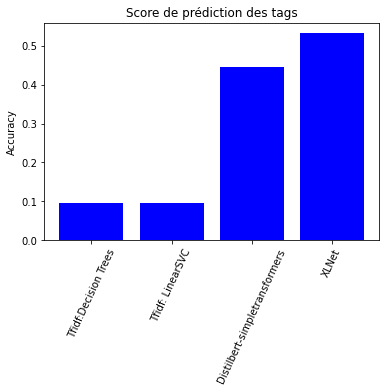

In [130]:
plt.bar(liste_modele,liste_accuracy,color='b')
plt.xticks(rotation=65)
plt.ylabel('Accuracy')
plt.title('Score de prédiction des tags')
plt.show()